## Introduction to LLM Intruction Finetuning

In [2]:
import tiktoken
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.nn import functional as f
from torch.utils.data import Dataset, DataLoader


### Utils

In [3]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

In [4]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

In [5]:
def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])

    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale,
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift,
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale,
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift,
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])

In [6]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):
    idx = idx.to(model.tok_emb.weight.device)
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # Filter logits with top_k sampling
        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float('-inf')).to(logits.device), logits)

        # Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # apply softmax to get probabilities
            probas = torch.softmax(logits, dim=-1)

            # sample from the distribution
            idx_next = torch.multinomial(probas, num_samples=1)

        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)

        if idx_next == eos_id:
            break

        idx = torch.cat((idx, idx_next), dim=1)

    return idx

In [7]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    idx = idx.to(model.tok_emb.weight.device)

    for _ in range(max_new_tokens):

        # Crop current context if it exceeds the supported context size,
        # E.g., if LLm support only 5 tokens, and the context size is 10
        # then only the last 5 token are used as context
        idx_cond = idx[:, -context_size:]

        with torch.no_grad():
            logits = model(idx_cond) # (B, seq_len, vocab_size)

        # Focus only on the last time step
        # (batch, n_tokens, vocab_size) becomes (batch, vocabz_size)
        logits = logits[:, -1, :]

        # apply softmax to get probabilities
        probas = torch.softmax(logits, dim=-1)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True) # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1) # (batch, n_tokens+1)
    return idx

In [8]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size= model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model,
            idx=encoded,
            max_new_tokens=50,
            context_size=context_size
        )

    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace('\n', ' ')) # Compact print format
    model.train()

### GPT-2 Model From Scratch

In [9]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))


class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]), ## Expansion
            GELU(), ## Activation
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]), ## Contraction
        )

    def forward(self, x):
        return self.layers(x)

In [10]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

In [11]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        # 2*4*768
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x
        # 2*4*768

In [12]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

### Preprating Dataset

In [13]:
import json
import os
import urllib
import ssl

def dowload_and_load_file(file_path, url):
    ssl_context = ssl.create_default_context()
    ssl_context.check_hostname = False
    ssl_context.verify_mode = ssl.CERT_NONE

    if not os.path.exists(file_path):
        with urllib.request.urlopen(url, context=ssl_context) as response:
            text_data = response.read().decode('utf-8')
        with open(file_path, 'w', encoding='utf-8')  as file:
            file.write(text_data)
    else:
        with open(file_path, 'r', encoding='utf-8') as file:
            text_data = file.read()

    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)

    return data

file_path = 'instruction-data.json'
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
)

data = dowload_and_load_file(file_path, url)
print('Number of entries:', len(data))

Number of entries: 1100


In [14]:
print('Example entry:\n', data[50])

Example entry:
 {'instruction': 'Identify the correct spelling of the following word.', 'input': 'Ocassion', 'output': "The correct spelling is 'Occasion.'"}


In [15]:
print('Another example entry:\n', data[999])

Another example entry:
 {'instruction': "What is an antonym of 'complicated'?", 'input': '', 'output': "An antonym of 'complicated' is 'simple'."}


#### Converting Instructions Into Alpaca Format

Some common intruction formats:
- Alpaca prompt style
- Phi 3 Microsoft prompt style

In [16]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry['input'] else ""

    return instruction_text + input_text

In [17]:
model_input = format_input(data[50])
desired_response = f"\n\n### Response:\n{data[50]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'


In [18]:
model_input = format_input(data[999])
desired_response = f"\n\n### Response:\n{data[999]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is an antonym of 'complicated'?

### Response:
An antonym of 'complicated' is 'simple'.


#### Splitting Data Into Train-Test-Validation Sets

In [19]:
train_portion = int(len(data) * 0.85) # 85% for training
test_portion = int(len(data) * 0.1)   # 10% for test
val_portion = len(data) - train_portion - test_portion # Remaining 5% for validation

train_data = data[:train_portion]
test_data = data[train_portion:train_portion+test_portion]
val_data = data[train_portion+test_portion:]

In [20]:
len(train_data), len(test_data), len(val_data)

(935, 110, 55)

### Organizing Data Into Training Batches

In [21]:
class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data

        self.encoded_texts = []
        for entry in data:
            intruction_plus_input = format_input(entry)
            response_text = f"### Response:\n{entry['output']}"
            full_text = intruction_plus_input + response_text
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)

Now, we'll implement custom collate function:
- Step 1: Find the longest sequence in the batch
- Step 2: Pad and prepare inputs
- Step 3: Remove extra padded token added earlier
- Step 4: Convert list of inputs to tensor and transfer to target device

In [22]:
def custom_collate_draft_1(batch, pad_token_id=50256, device='cpu'):
    # Find the longest sequence in the batch
    # and increase the max length by +1, which will add one extra
    # padding token below
    batch_max_length = max(len(item)+1 for item in batch)

    inputs_lst = []
    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]

        padded = (
            new_item + [pad_token_id] * (batch_max_length - len(new_item))
        )

        # Via padded[:-1], we remove the extra padded token
        # that has been added via the +1 setting in batch_max_length
        # (the extra padding token will be relevant in later codes)
        inputs = torch.tensor(padded[:-1])
        inputs_lst.append(inputs)

    inputs_tensor = torch.stack(inputs_lst).to(device)
    return inputs_tensor

In [23]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

print(custom_collate_draft_1(batch))

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])


#### Creating Target Token IDs for Training

In [24]:
def custom_collate_draft_2(batch, pad_token_id=50256, device='cpu'):
    # Find the longest sequence in the batch
    # and increase the max length by +1, which will add one extra
    # padding token below
    batch_max_length = max(len(item)+1 for item in batch)

    inputs_lst, targets_lst = [], []
    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]

        padded = (
            new_item + [pad_token_id] * (batch_max_length - len(new_item))
        )

        inputs = torch.tensor(padded[:-1]) # Truncate the last token for inputs
        targets = torch.tensor(padded[1:]) # Shift +1 to the right for targets
        inputs_lst.append(inputs)
        targets_lst.append(targets)

    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor

In [25]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

input_tensor, target_tensor = custom_collate_draft_2(batch)

print('Inputs:\n', input_tensor)
print('\nTargets:\n', target_tensor)

Inputs:
 tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])

Targets:
 tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])


In the next step, we assign a -100 placeholder value to all padding tokens.

This special value allows us to exclude these padding tokens from contrubting to the training loss calculation.

**Note:** We retain one end-of-text token, ID 50256, in the target list. This allows the LLM to learn when to generate an end-of-text token in response to instruction, which we use as an indicator that the generated response is completed

In [26]:
def custom_collate_fn(
    batch,
    pad_token_id=50256,
    ignore_index=-100,
    allowed_max_length=None,
    device='cpu'
):
    batch_max_length = max(len(item)+1 for item in batch)

    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]

        padded = (new_item + [pad_token_id] * (batch_max_length - len(new_item)))

        inputs = torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:])

        # Replace all but the first padding tokens in targets by ignore_index
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index

        # Optionally truncate to maximum sequence length
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)

    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)

    return inputs_tensor, targets_tensor

In [27]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

input_tensor, target_tensor = custom_collate_fn(batch)

print('Inputs:\n', input_tensor)
print('\nTargets:\n', target_tensor)

Inputs:
 tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])

Targets:
 tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


#### Understanding the logic behind modified collate function

In [28]:
logits_1 = torch.tensor(
    [[-1.0, 1.0], # 1st training example
     [-0.5, 1.5]] # 2nd training exmaple
)

targets_1 = torch.tensor([0, 1])

loss_1 = f.cross_entropy(logits_1, targets_1)
print(loss_1)

tensor(1.1269)


In [29]:
## Adding an additional token ID will, as we would expect, affect the loss function
logits_2 = torch.tensor(
    [[-1.0, 1.0],
     [-0.5, 1.5],
     [-0.5, 1.5]] # New 3rd training example

)

targets_2 = torch.tensor([0, 1, 1])

loss_2 = f.cross_entropy(logits_2, targets_2)
print(loss_2)

tensor(0.7936)


In [30]:
## If we replace the third target token ID with -100 (default ignore_index paramteter)
targets_3 = torch.tensor([0, 1, -100])

loss_3 = f.cross_entropy(logits_2, targets_3)
print(loss_3)

tensor(1.1269)


#### Masking Target Token IDs

It is also common to mask out the target token IDs that correspond to the instruction.

By masking out the target token IDs that correspond to the instruction, the LLM cross entropy loss is only computed for the generated response target IDs.

By masking out the target tokens, the model is trained to focus on generating accurate responses rather than additionally also memorizing instructions, which can help with reducing overfitting.

Currently, researches are divided on whether masing the instructions is universally benefical during instruction finetuning.

For instance, a recent paper titled "Instruction Tuning With Loss Over Instructions" demonstrated that not masking the instructions benefits the LLM performance.

### Creating DataLoaders From An Instruction Dataset

The custom_collate_fn includes code to move the input and target tensors (for
example, torch.stack(inputs_lst).to(device)) to a specified device, which can be
either "cpu" or "cuda" (for GPUs), or optionally "mps" for Macs with Apple Silicon chips.

In previous chapters, we moved the data onto the target device (for example, the GPU
memory when device="cuda") in the main training loop. Having this as part of the collate
function offers the advantage of performing this device transfer process as a background
process outside the training loop, preventing it from blocking the GPU during model
training.

In [31]:
tokenizer = tiktoken.get_encoding('gpt2')

In [32]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

# device = 'cuda' if torch.cuda.is_available() else 'cpu'

print('device:', device)

device: mps


In [33]:
from functools import partial

customized_collate_fn = partial(custom_collate_fn, device=device, allowed_max_length=1024)

In [34]:
num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

In [35]:
print("Train Loader:")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)

Train Loader:
torch.Size([8, 59]) torch.Size([8, 59])
torch.Size([8, 74]) torch.Size([8, 74])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 63]) torch.Size([8, 63])
torch.Size([8, 70]) torch.Size([8, 70])
torch.Size([8, 78]) torch.Size([8, 78])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 60]) torch.Size([8, 60])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 60]) torch.Size([8, 60])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 64]) torch.Size([8, 64])
torch.Size([8, 81]) torch.Size([8, 81])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 78]) torch.Size([8, 78])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 63]) torch.Size([8, 63])
torch.Size([8, 66]) torch.

### Loading Pre-trained LLM Weights (GPT-2 355M)

In [36]:
from gpt_download3 import download_and_load_gpt2

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
    model_size=model_size,
    models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

Using TensorFlow backend.
/opt/miniconda3/lib/python3.12/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/355M/checkpoint


/opt/miniconda3/lib/python3.12/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/355M/encoder.json


/opt/miniconda3/lib/python3.12/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/355M/hparams.json


/opt/miniconda3/lib/python3.12/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/355M/model.ckpt.data-00000-of-00001


/opt/miniconda3/lib/python3.12/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/355M/model.ckpt.index


/opt/miniconda3/lib/python3.12/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/355M/model.ckpt.meta


/opt/miniconda3/lib/python3.12/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/355M/vocab.bpe


#### Test Pre-Trained Model on Instruction Based Tasks

Before diving into finetuning the model, let's take a moment to assess the pretrained LLM's performance on on of the validation tasks by comparing its output to the expected response.

In [37]:
torch.manual_seed(123)
input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [38]:
token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG['context_length'],
    eos_id=50256
)

generated_text = token_ids_to_text(token_ids, tokenizer)


In [39]:
response_text = generated_text[len(input_text):].strip()
print(response_text)

### Response:

The chef cooks the meal every day.

### Instruction:

Convert the active sentence to passive: 'The chef cooks the


As we can see from the output, the pretrained model is not yet capable of correctly following the given instruction.

While it does create a "Response" section, it simply repeats the original input sentence and part of the instruction, failiting to convert the active sentence to passive voice as requested.

### Finetuning the LLM on Instruction Data

#### Training Utils

Step 1: Set model to training mode

Step 2: Reset loss gradients from previous batch iteration

Step 3: Calculate loss gradients

Step 4: Update model weights using loss gradients

Step 5: New: track examples instead of tokens

Step 6: Optional evaluation step

Step 7: Optionally calculate accuracy after each epoch

In [40]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch) # (B, Seq_len, vocab_size)
    loss = f.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss

def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float('nan')
    elif num_batches == None:
        num_batches == len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))

    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss
        else:
            break
    return total_loss / num_batches

def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, eval_iter)
    model.train()
    return train_loss, val_loss

In [41]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):

    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            tokens_seen += input_batch.numel() # Return total number of elements
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(model, train_loader, val_loader,
                                                      device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen

#### Finetune the Pre-Trained Model

In [42]:
## INITIAL LOSS OF MODEL ON TRAIN AND VALIDATION DATALOADERS

model.to(device)

torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)

print('Training Loss:', train_loss.item())
print('Validation Loss', val_loss.item())

Training Loss: 4.168272972106934
Validation Loss 4.1019439697265625


In [44]:
## Start Context

print(format_input(val_data[0]))

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [45]:
import time

start_time = time.time()

torch.manual_seed(123)

model.to(device)
optimizer = torch.optim.AdamW(params=model.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 3
train_losses, val_losses, tokens_seen = train_model_simple(model,
                                                          train_loader,
                                                          val_loader,
                                                          optimizer=optimizer,
                                                          device=device,
                                                          num_epochs=num_epochs,
                                                          eval_freq=10,
                                                          eval_iter=5,
                                                          start_context=format_input(val_data[0]),
                                                          tokenizer=tokenizer)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.735, Val loss 2.730
Ep 1 (Step 000010): Train loss 1.053, Val loss 0.985
Ep 1 (Step 000020): Train loss 0.784, Val loss 0.923
Ep 1 (Step 000030): Train loss 0.771, Val loss 0.861
Ep 1 (Step 000040): Train loss 0.689, Val loss 0.838
Ep 1 (Step 000050): Train loss 0.661, Val loss 0.817
Ep 1 (Step 000060): Train loss 0.691, Val loss 0.775
Ep 1 (Step 000070): Train loss 0.633, Val loss 0.755
Ep 1 (Step 000080): Train loss 0.601, Val loss 0.745
Ep 1 (Step 000090): Train loss 0.539, Val loss 0.727
Ep 1 (Step 000100): Train loss 0.579, Val loss 0.709
Ep 1 (Step 000110): Train loss 0.623, Val loss 0.696
Below is an instruction that describes a task. Write a response that appropriately completes the request.  ### Instruction: Convert the active sentence to passive: 'The chef cooks the meal every day.'### Response: The meal is prepared every day by the chef.<|endoftext|>The following is an instruction that describes a task. Write a response that appropriately com

#### Plotting Training and Validation Loss Curves

In [46]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Convert train_losses and val_losses to lists of Python scalars
    train_losses = [loss.cpu().item() for loss in train_losses]
    val_losses = [loss.cpu().item() for loss in val_losses]

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

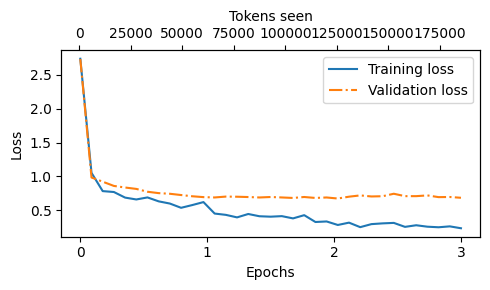

In [47]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

As we cann se in the loss plot shown above, the model's performance on both the training and validation sets improves substantially over the course of training.

The rapid decrease in losses during the initial phase indicates that the model is quickly learning meaningful patterns and representations from the data. Then, as training progresses to the second epoch, the losses continue to decrease but at slower rate, suggesting that the model is finetuning its learning representations and converging to a stable solution.

### Extracting and Saving Responses

After finetuning the LLM on the training portion of the instruction dataset as described in the previous section, we now proceed to evaluation its performance on the held-out test set.

To accomplish this, we first extract the model-generated responses for each input in the test dataset and collect them for manual analsis.

In [48]:
torch.manual_seed(123)

for entry in test_data[:5]:
  input_text = format_input(entry)

  token_ids = generate(
      model,
      idx=text_to_token_ids(input_text, tokenizer),
      max_new_tokens=256,
      context_size=BASE_CONFIG['context_length'],
      eos_id=50256
  )

  generated_text = token_ids_to_text(token_ids, tokenizer)
  response_text = (
      generated_text[len(input_text):]
      .replace('### Response:', "")
      .strip()
  )

  print(input_text)
  print(f"\nCorrect response:\n>> {entry['output']}")
  print(f"\nModel response:\n>> {response_text.strip()}\n")
  print('---'*50)


Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a bullet.

------------------------------------------------------------------------------------------------------------------------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

Correct response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> The type of cloud typically associated with thunderstorms is a cumulus cloud.

------------------------------------------------------------------------------------------------------------------------------------------------------
Below is an 

As we can see based on the test set instructions, given responses, and the model's responses, the model performs relatively well.

But there are some wrong or suspicious answers given by the model, therefor we need an approach to calculate evaluation (performance) score of our model to understand if it's working well or bad on the held-out test data.

Most importantly, we can see that model evaluation is not as straightforward as in the
previous chapter, where we simply calculated the percentage of correct spam/non-spam
class labels to obtain the classification accuracy.

In practice, instruction-finetuned LLMs
such as chatbots are evaluated via multiple approaches:

1. Short-answer and multiple choice benchmarks such as MMLU ("Measuring
Massive Multitask Language Understanding," https://arxiv.org/abs/2009.
03300), which test the general knowledge of a model.

2. Human preference comparison to other LLMs, such as LMSYS chatbot
arena (https://arena.lmsys.org).

3. Automated conversational benchmarks, where another LLM like GPT-4 is
used to evaluate the responses, such as AlpacaEval (https://tatsulab.github.io/alpaca_eval/).
completes the request.

#### Collecting LLM responses in JSON format

In [ ]:
for i, entry in tqdm(enumerate(test_data), total=len(test_data)):
  input_text = format_input(entry)

  token_ids = generate(
      model,
      idx=text_to_token_ids(input_text, tokenizer),
      max_new_tokens=256,
      context_size=BASE_CONFIG['context_length'],
      eos_id=50256
  )

  generated_text = token_ids_to_text(token_ids, tokenizer)
  response_text = generated_text[len(input_text):].replace('### Response:', "").strip()

  test_data[i]['model_response'] = response_text

with open('instruction-data-with-response.json', 'w') as file:
  json.dump(test_data, file, indent=4) # "indent" for pretty-printing

  0%|          | 0/110 [00:00<?, ?it/s]


AttributeError: 'str' object has no attribute 'tok_emb'

In [53]:
test_data[0]

{'instruction': 'Rewrite the sentence using a simile.',
 'input': 'The car is very fast.',
 'output': 'The car is as fast as lightning.',
 'model_response': 'The car is as fast as a bullet.'}

#### Save the model as `gpt-2-medium355M-sft.pth`

In [48]:
# import re

# file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL)}-sft.pth"
# torch.save(model.state_dict(), file_name)
# print(f"Model saved as {file_name}")

# Load model via
model.load_state_dict(torch.load("gpt2-medium355M-sft.pth", map_location=torch.device('mps')))

/var/folders/sf/m8d1jsv948q75r24_12s_sg00000gn/T/ipykernel_23410/693254910.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("gpt2-medium3

<All keys matched successfully>

### Evaluting the Fine-Tuned LLM

To implement the evaluation step which involves evaluating test set responses in an automated fashion, we utilize an existing instruction-finetuned 8b parameter LLama 3 model developed by Meta AI.

This model can be run locally using the open-source Ollama aplication.

In [51]:
import psutil

def check_if_running(process_name):
    running = False
    for proc in psutil.process_iter(['name']):
        if process_name in proc.info['name']:
            running = True
            break
    return running

ollama_running = check_if_running('ollama')
if not ollama_running:
    raise RuntimeError('Ollama not running. Launch ollama before proceeding.')
print('Ollama running:', check_if_running('ollama'))

Ollama running: True


In [53]:
import urllib.request

def query_model(
    prompt,
    model='llama3',
    url='http://localhost:11434/api/chat'
):
    # Create the data payload as a dictionary
    data = {
        "model": model,
        "messages": [
            {"role": "user", "content": prompt}
        ],
        "options": {  # Settings below are required for deterministic responses
            "seed": 123,
            "temperature": 0,
            "num_ctx": 2048
        }
    }
    
    # Convert the dictionary to a JSON formatted string and encode it to bytes
    payload = json.dumps(data).encode('utf-8')
    
    # Craete a request object, settting the method to POST and adding necessary headers
    request = urllib.request.Request(
        url,
        data=payload,
        method='POST'
    )
    request.add_header("Content-Type", "application/json")
    
    # Send the request and capture the response
    response_data = ""
    with urllib.request.urlopen(request) as response:
        # Read and decode the response
        while True:
            line = response.readline().decode('utf-8')
            if not line:
                break
            response_json = json.loads(line)
            response_data += response_json['message']['content']
    
    return response_data

In [54]:
# Demo

model = "llama3"
result = query_model("What do Llamas eat?", model)
print(result)

Llamas are herbivores, which means they primarily feed on plant-based foods. Their diet typically consists of:

1. Grasses: Llamas love to graze on various types of grasses, including tall grasses, short grasses, and even weeds.
2. Hay: High-quality hay, such as alfalfa or timothy hay, is a staple in a llama's diet. They enjoy the sweet taste and texture of fresh hay.
3. Grains: Llamas may receive grains like oats, barley, or corn as part of their daily ration. However, it's essential to provide these grains in moderation, as they can be high in calories.
4. Fruits and vegetables: Llamas enjoy a variety of fruits and veggies, such as apples, carrots, sweet potatoes, and leafy greens like kale or spinach.
5. Minerals: Llamas require access to mineral supplements, which help maintain their overall health and well-being.

In the wild, llamas might also eat:

1. Leaves: They'll munch on leaves from trees and shrubs, including plants like willow, alder, and birch.
2. Bark: In some cases, ll

In [56]:
test_data[0]

{'instruction': 'Rewrite the sentence using a simile.',
 'input': 'The car is very fast.',
 'output': 'The car is as fast as lightning.'}

In [60]:
# # Load the test data
# with open('instruction-data-with-response.json', 'r') as file:
#     test_data = json.load(file)
# test_data[0]

{'instruction': 'Rewrite the sentence using a simile.',
 'input': 'The car is very fast.',
 'output': 'The car is as fast as lightning.',
 'model_response': 'The car is as fast as a bullet.'}

In [66]:
for entry in test_data[:3]:
    prompt = (
        f"Given the input `{format_input(entry)}` "
        f"and corret output `{entry['output']}`, "
        f"score the model response `{entry['model_response']}`"
        f" on a scale from 0 to 100, where 100 is the best score."
    )
    
    print('\nDataset response')
    print('>>', entry['output'])
    print('\nModel response:')
    print('>>', entry['model_response'])
    print('\nScore:')
    print('>>', query_model(prompt))
    print('\n---------------------------------------')


Dataset response
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a bullet.

Score:
>> I'd rate the model response "The car is as fast as a bullet." an 85 out of 100.

Here's why:

* The response uses a simile correctly, comparing the speed of the car to something else (in this case, a bullet).
* The comparison is relevant and makes sense, as bullets are known for their high velocity.
* The phrase "as fast as" is used correctly to introduce the simile.

The only reason I wouldn't give it a perfect score is that some people might find the comparison slightly less vivid or evocative than using lightning (which is often associated with speed and power). However, "as fast as a bullet" is still a strong and effective simile that effectively conveys the idea of the car's speed.

---------------------------------------

Dataset response
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> The type of cloud typically as

In [67]:
for entry in test_data[:3]:
    prompt = (
        f"Given the input `{format_input(entry)}` "
        f"and corret output `{entry['output']}`, "
        f"score the model response `{entry['model_response']}`"
        f" on a scale from 0 to 100, where 100 is the best score. "
        f"Respond with the integer number only."
    )
    
    print('\nDataset response')
    print('>>', entry['output'])
    print('\nModel response:')
    print('>>', entry['model_response'])
    print('\nScore:')
    print('>>', query_model(prompt))
    print('\n---------------------------------------')


Dataset response
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a bullet.

Score:
>> 85

---------------------------------------

Dataset response
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> The type of cloud typically associated with thunderstorms is a cumulus cloud.

Score:
>> 40

---------------------------------------

Dataset response
>> Jane Austen.

Model response:
>> The author of 'Pride and Prejudice' is Jane Austen.

Score:
>> 98

---------------------------------------


In [70]:
def generate_model_score(json_data, json_key, model='llama3'):
    scores = []
    for entry in tqdm(json_data, desc="Scoring entries"):
        prompt = (
            f"Given the input `{format_input(entry)}` "
            f"and corret output `{entry['output']}`, "
            f"score the model response `{entry[json_key]}`"
            f" on a scale from 0 to 100, where 100 is the best score. "
            f"Respond with the integer number only."
        )
        score = query_model(prompt, model)
        try:
            scores.append(int(score))
        except ValueError:
            print(f"Could not convert score: {score}")
            continue
    return scores

In [76]:
general_score_over_test_data = generate_model_score(test_data, json_key='model_response')

print(np.mean(general_score_over_test_data))

Scoring entries: 100%|██████████| 110/110 [00:43<00:00,  2.55it/s]

51.09090909090909
